# Data Visualization & Analysis of Electricity Data

**Submitted by: Asmita Poddar**

*Note: Since the Kaggle kernel has a problem in rendering R plot_ly plots, I have created a [plotly account](https://plot.ly/r/getting-started/), created APIs for the plots and included the links to the plots in this notebook.*

In [1]:
library(tidyverse) # metapackage with lots of helpful functions
list.files(path = "../input")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1.9000     ✔ purrr   0.3.2     
✔ tibble  2.1.1          ✔ dplyr   0.8.1     
✔ tidyr   0.8.3          ✔ stringr 1.4.0     
✔ readr   1.3.1          ✔ forcats 0.4.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


[1] "electricity"                "test-consumption-predicted"

In [2]:
library(lubridate)
library(zoo)
library(plotly)
library(forecast)
library(xts)
library(tseries)
library(gplots)
library(reshape2)


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘plotly’

The following object is masked from ‘package:ggplot2’:

    last_plot

The following object is masked from ‘package:stats’:

    filter

The following object is masked from ‘package:graphics’:

    layout

The following object is masked from ‘package:httr’:

    config

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff

Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last


Attaching package: ‘gplots’

The following object is masked from ‘package:

# Reading the Data
Datasets used:
* `train_electricity.csv`: Provided by EEML
* `test_electricity.csv`: Provided by EEML
* `baseline_improved.csv`: I have used the baseline sample submissions for the year 2018-2019 (RMSE score 506.63) from the Kaggle competition
#### To understand the structure of the data. I have extracted features like `Year`, `Month`, `Week`, `Day`, `Dayofyear`, `Dayofweek`, `Quarter`, `Hour`, `Minute` to further analyse the data at these levels.

*Note: Throughout the rest of the notebook, by `features`, I mean the different components of electricity production, i.e., Coal, Gas, Hydroelectric, Nuclear, Wind, Solar, Biomass.*

In [3]:
train  = read_csv("../input/electricity/train_electricity.csv")
train$Date = as_datetime(train$Date)
test  = read_csv("../input/electricity/test_electricity.csv")
test$Date = as_datetime(test$Date)
test_consumption_pred = read_csv("../input/test-consumption-predicted/baseline_improved.csv")

Parsed with column specification:
cols(
  Date = col_double(),
  Consumption_MW = col_double(),
  Coal_MW = col_double(),
  Gas_MW = col_double(),
  Hidroelectric_MW = col_double(),
  Nuclear_MW = col_double(),
  Wind_MW = col_double(),
  Solar_MW = col_double(),
  Biomass_MW = col_double(),
  Production_MW = col_double()
)
Parsed with column specification:
cols(
  Date = col_double(),
  Coal_MW = col_double(),
  Gas_MW = col_double(),
  Hidroelectric_MW = col_double(),
  Nuclear_MW = col_double(),
  Wind_MW = col_double(),
  Solar_MW = col_double(),
  Biomass_MW = col_double(),
  Production_MW = col_double()
)
Parsed with column specification:
cols(
  Date = col_double(),
  Consumption_MW = col_double()
)


In [4]:
add_datetime_features <- function(df)
{
    features = c("Year", "Month", "Week", "Day", "Dayofyear", "Dayofweek", "Quarter", "Hour", "Minute")
    df = cbind(df, "Year" = year(df$Date))
    df = cbind(df, "Month" = month(df$Date))
    df = cbind(df, "Week" = week(df$Date))
    df = cbind(df, "Day" = day(df$Date))
    df = cbind(df, "Dayofyear" = as.numeric(strftime(df$Date, format = "%j")))
    df = cbind(df, "Dayofweek" = wday(df$Date))
    df = cbind(df, "Quarter" = quarters(df$Date))
    df = cbind(df, "Hour" = hour(df$Date))
    df = cbind(df, "Minute" = minute(df$Date))           
    return (df)
}
df = add_datetime_features(train)
df_test = add_datetime_features(test)
df_test_con_pred = add_datetime_features(test_consumption_pred)
df$actualprod = rowSums(df[,3:9])
summary(df)

ERROR: Error in as.POSIXlt.numeric(x, tz = tz(x)): 'origin' must be supplied


From the data, we see that the columns `Coal_MW`, `Gas_MW` and `Solar_MW` have negative values. The reason for the negative values is uncertain. One possible reason is that the electricity required to run and maintain the plant is more than the electricity being generated. Another reason could be human or device error in measurement. However, net electricity is generated.

In [5]:
g=nrow(df[df$Gas_MW<0,1:10])/nrow(df)*100
w=nrow(df[df$Wind_MW<0,1:10])/nrow(df)*100
s=nrow(df[df$Solar_MW<0,1:10])/nrow(df)*100
print(paste0("Percentage of negative Gas_MW values: ",g))
print(paste0("Percentage of negative Wind_MW values: ", w))
print(paste0("Percentage of negative Solar_MW values: ", s))
neg_energy = do.call("rbind", list(df[df$Coal_MW<0,1:10],df[df$Gas_MW<0,1:10], df[df$Wind_MW<0,1:10], df[df$Solar_MW<0,1:10]))
print("Yearwise negative values for solar energy:")
for (y in unique(df$Year))
    print(paste0("For ", y, ": ", nrow(df[df$Solar_MW<0&df$Year==y,1:10])/nrow(df)*100, "%"))

[1] "Percentage of negative Gas_MW values: 0.000238434155215866"
[1] "Percentage of negative Wind_MW values: 2.7455692973107"
[1] "Percentage of negative Solar_MW values: 18.6634334995219"
[1] "Yearwise negative values for solar energy:"
[1] "For 2010: 0%"
[1] "For 2011: 0%"
[1] "For 2012: 0%"
[1] "For 2013: 0%"
[1] "For 2014: 2.09798213174441%"
[1] "For 2015: 5.6864161677432%"
[1] "For 2016: 5.60606385743545%"
[1] "For 2017: 5.2281457214183%"
[1] "For 2018: 0.0448256211805829%"


In [6]:
unique_years = unique(df$Year)
df_year = list()
for (u in unique_years)
    df_year = append(df_year,list(df[df$Year==u,]))

# Yearwise plot of Production and Consumption

In [7]:
yearwise = df[df$Year!=2018, ]
yearwise = yearwise[,2:12] %>%  group_by(Year, Month) %>%  summarise_each(list(mean))
yearwise = df[df$Year!=2018, ]
yearwise = yearwise[,2:12] %>%  group_by(Year) %>%  summarise_each(list(mean))
colours = c("red", "green", "orange", "pink", "yellow", "purple", "black", "cyan", "blue")
p = plot_ly(yearwise, x = ~Year)
j=1
for (i in 2:ncol(yearwise))
{
    p = p %>% add_lines(y = yearwise[[i]], name = colnames(yearwise)[i], line = list(color = colours[j]))
    j=j+1
}

The [plot above](https://plot.ly/~asmitapoddar/12) shows the year wise breakdown of production and consumption of electricity. The total production of electricity has been increasing over the years and so has consumption. It can be seen that the total production is significantly greater than the total consumption of electricity.

In [8]:
t = vector()
i=1
for (y in unique(df$Year))
{
    t = c(t, yearwise$Production_MW[yearwise$Year==y]/yearwise$Consumption_MW[yearwise$Year==y]*100)
    print(paste0("Percentage of MW Produced as a function of Conumption in Year ", y, ": ", t[i]))
    i=i+1
}
print(mean(t, na.rm=T))

[1] "Percentage of MW Produced as a function of Conumption in Year 2010: 105.32097151656"
[1] "Percentage of MW Produced as a function of Conumption in Year 2011: 103.418001736923"
[1] "Percentage of MW Produced as a function of Conumption in Year 2012: 99.8316783832786"
[1] "Percentage of MW Produced as a function of Conumption in Year 2013: 103.79570150914"
[1] "Percentage of MW Produced as a function of Conumption in Year 2014: 112.915050946695"
[1] "Percentage of MW Produced as a function of Conumption in Year 2015: 111.870005091583"
[1] "Percentage of MW Produced as a function of Conumption in Year 2016: 108.65454157635"
[1] "Percentage of MW Produced as a function of Conumption in Year 2017: 104.900688138114"
[1] "Percentage of MW Produced as a function of Conumption in Year 2018: NA"
[1] 106.3383


On an average, Romania produces *106.338% *of its electricity consumption needs. Thus, Romania is self-sustainable in its electricity production. The excess electricity that Romania produces can be exported. 

# Monthwise plot of Production and Consumption Over the Years

In [9]:
func_year<-function(df)
{
    cols = 1:10
    df1 = df[,c(cols,12,20)]  #Col 12 for Month, Col 20 for actualprod
    df1 = df1[,-1]
    df1
}
df_year_sliced = lapply(df_year, func_year)
df_year_month = lapply(df_year_sliced, function(x) x %>%  group_by(Month) %>%  summarise_each(funs(sum)))
                       
df_year_month_merged = do.call("cbind", list(df_year_month[[1]], df_year_month[[2]], df_year_month[[3]], df_year_month[[4]], df_year_month[[5]], df_year_month[[6]], df_year_month[[7]], df_year_month[[8]], df_year_month[[9]]))
monthnames = c('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')
df_year_month_merged$Monthnames = factor(monthnames, levels = monthnames)

ERROR: Error in `[.data.frame`(df, , c(cols, 12, 20)): undefined columns selected


In [10]:
colours = c("red", "green", "orange", "pink", "yellow", "purple", "black", "cyan", "blue", "darkgoldenrod1")
p = plot_ly(df_year_month_merged, x = ~Monthnames)
j=1
c = 0
for (i in 1:ncol(df_year_month_merged))
{
    if(i%%11==1)
    {
        j=1
        next
    }
    if(i%%11==0)
    {
       p = p %>% add_trace(y = df_year_month_merged[[i]], type = 'scatter', mode = 'lines',
            fill = 'tonexty', fillcolor='rgba(0,100,80,0.2)', line = list(color = 'rgba(0,100,80,1)'),
            showlegend = TRUE, name = 'Theoretical Production')
        next
    }    
    p = p %>% add_lines(y = df_year_month_merged[[i]], name = colnames(df_year_month_merged)[i], line = list(color = colours[j]))
    j=j+1
    c = c+1
}

t = list()
for (i in 1:10)
    t[[i]] = c(rep(F, (i-1)*10), rep(T, 10), rep(F, (10-i)*10))

p <- p %>% 
  layout(
    title = "Month Wise Energy Production and Consumption from 2010 -- 2018",
    xaxis = list(title="Month", label= c('1','2','3','4','5','6','7','8','9','9','89', '100')),
    yaxis = list(title = "Energy (in MW)"),
    updatemenus = list(
        list(
        y = 0.7,
        buttons = list(
          list(method = "restyle",
               args = list("visible", as.list(t[[1]])),
               label = "2010"),

          list(method = "restyle",
               args = list("visible", as.list(t[[2]])),
               label = "2011"),
          
        list(method = "restyle",
               args = list("visible", as.list(t[[3]])),
               label = "2012"),
            
        list(method = "restyle",
               args = list("visible", as.list(t[[4]])),
               label = "2013"),

          list(method = "restyle",
               args = list("visible", as.list(t[[5]])),
               label = "2014"),
          
        list(method = "restyle",
               args = list("visible", as.list(t[[6]])),
               label = "2015"),
            
        list(method = "restyle",
               args = list("visible", as.list(t[[7]])),
               label = "2016"),

          list(method = "restyle",
               args = list("visible", as.list(t[[8]])),
               label = "2017"),
          
        list(method = "restyle",
               args = list("visible", as.list(t[[9]])),
               label = "2018"))
        )))

ERROR: Error in is.data.frame(data): object 'df_year_month_merged' not found


[This Month Wise Energy Production and Consumption from 2010 -- 2018](https://plot.ly/~asmitapoddar/14/#/) plot shows the monthwise distribution of the various sources of production and consumption of electricity. The dropdown consists of the various years for which the plots can be visualized individually.

It can be noted that the theoretical production of electricity, i.e., the actual sum of electricity produced from all the sources is slightly higher than the production as listed in the given dataset. The theoretical production has been shown with a dark green line and the shaded area between the Theoretical Production and Production_MW shows the difference in the values, which is not very significant. This difference can be accounted for by the negative values present in the dataset for some of the features of production.


# Box Plot

Boxplot gives a nice summary of numeric variables. The line that divides the box into 2 parts represents the median of the data. The end of the box shows the upper and lower quartiles. The extreme lines shows the highest and lowest value excluding outliers. 

In [11]:
no_of_each_hour = table(df$Hour)
unique_hour = sort(unique(df$Hour))
bnw = data.frame(hour=NULL, type=NULL, mw=NULL)
temp = data.frame(hour=NULL, type=NULL, mw=NULL)
for (i in 1:length(unique_hour))
{
    for (j in 2:10)
    {
        temp = data.frame(hour = rep(unique_hour[i], no_of_each_hour[i]), 
                          type = rep(colnames(df)[j], no_of_each_hour[i]), mw=as.numeric( df[[j]][df[[18]]==unique_hour[i]]) )
        bnw = rbind(bnw, temp)
    }
}

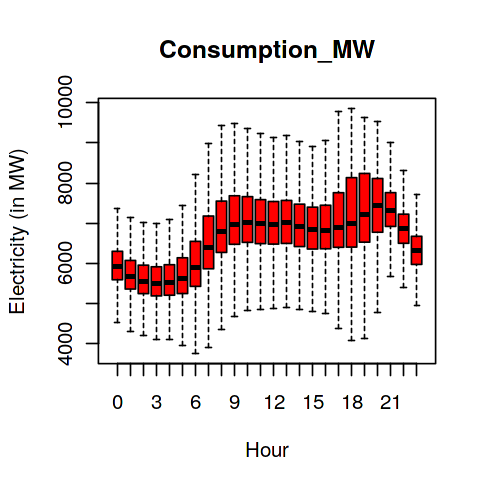

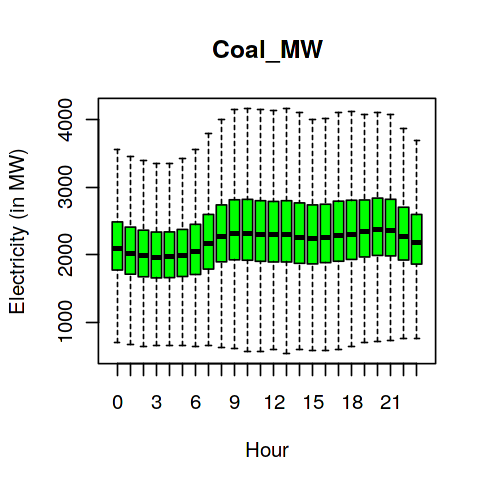

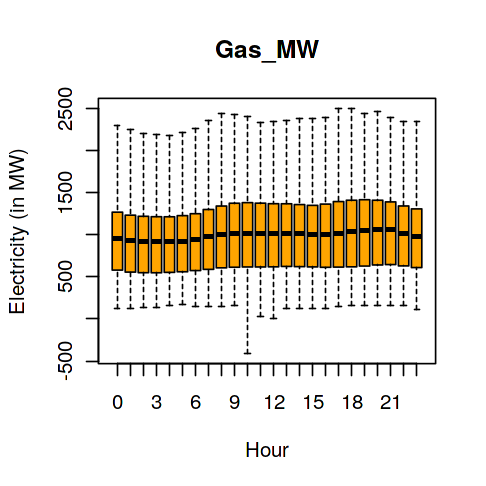

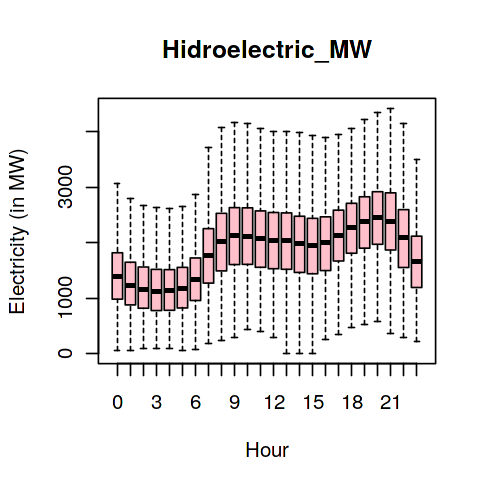

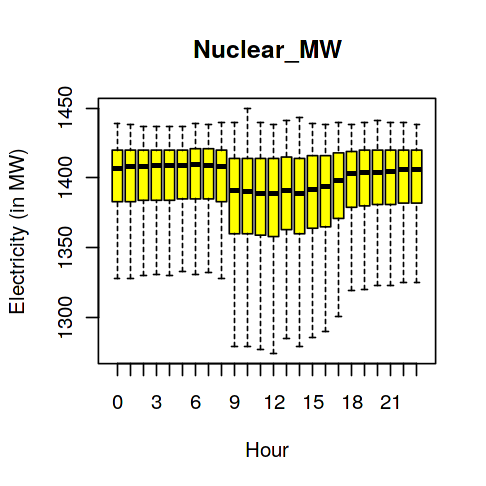

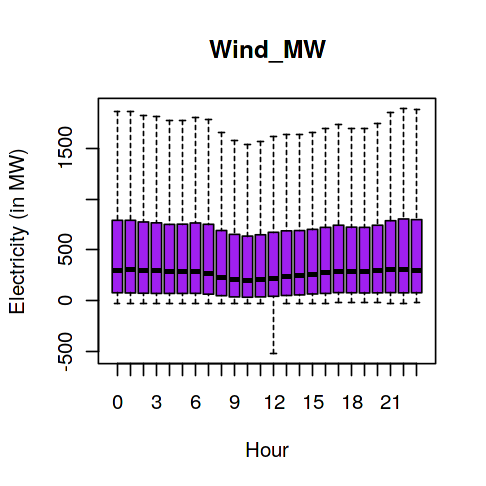

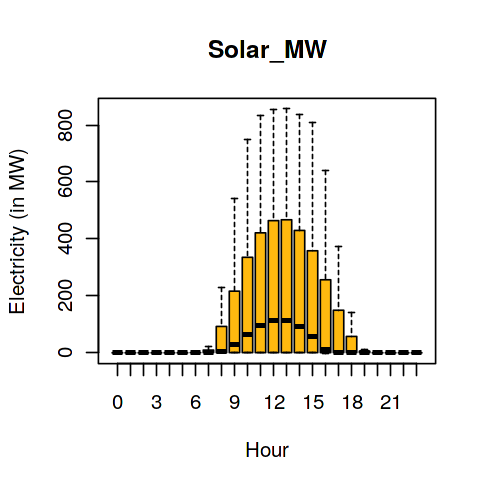

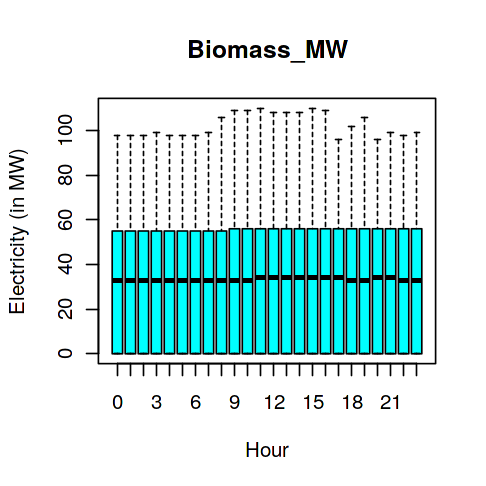

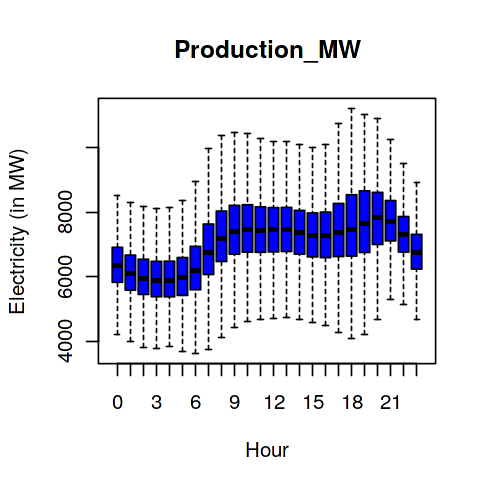

In [12]:
bb=list()
for (i in 2:10)
{
 bb[[i-1]]=bnw[bnw$type==colnames(df)[i],]
}

options(repr.plot.width=4.05, repr.plot.height=4.05)
for (i in 1:length(bb))
{
    if(colours[i]=="black")
        colours[i]="darkgoldenrod1"
    boxplot(mw~hour,data=bb[[i]], main=colnames(df)[i+1], xlab="Hour", ylab="Electricity (in MW)", col=colours[i], outline=F)
}


### Analysis

I have grouped the data according to hours of the day to get a sense of the distribution of features over the 24 hours of the day.

* Consumption of power is more during 1700 to 1900 hours. It should be noted that the time of evening hours changes with seasons. The Consumption is lowest in the hours before dawn when everyone is sleeping. 
* The production of electricity from Coal is slightly higher during the industrial working hours of the day. The production slightly dips during late night and dawn.
* The production of electricity from Gas remains more or less constant irrespective of the hours of the day without much variation. The lowest value of -500 MW would be an anomalous value.
* The production of electricity from Hydroelectricity is maximum during the daytime and minimum in the hours before dawn; the maximum being generated around 2000 hrs.
* The production of Nuclear energy is higher during dawn and early morning than during the rest of the day.
* The production Wind energy remains more or less constant irrespective of the hours of the day without much variation. The lowest value of -500 MW would be an anomalous value.
* The production of Solar energy is highest during the hours of sunshine and zero at night. The sun shines from 0900 to 1600 hrs during both the summer and winter and maximum energy is generated during this period.
* The production Biomass energy remains more or less constant irrespective of the hours of the day without much variation.

# Seasonal Decomposition

The the following section, I have performed time series decomposition of the various sources of production and consumption of electricity.
I have done this in the following steps:
1. I converted the data to a time series. I have evaluated the data using 'monthly' intervals (frequency = 12).
2. I split the time series into three components: seasonality, trends and random fluctuation. 
    * I have used `additive model` for my time series decomposition since seasonal fluctuations are roughly constant in size over time and do not seem to depend on the level of the time series, and the random fluctuations seem to be constant over time.
    * The trend tells us how things are chanding overall.
    * Randomness is the component not explained by seasonality or trend.
3. Each factor has been depicted with a different colour.

## Decomposition of Total Energy

In [13]:
monthwise = df[,2:12] %>%  group_by(Year, Month)  %>% summarise_each(funs(mean))
monthwise.ts = ts(monthwise, frequency=12, start=c(2010,1), end=c(2018,1))
monthwise_pred.ts = ts(monthwise, frequency=12, start=c(2010,1), end=c(2017,12))

monthwise_test = df_test[,2:11] %>%  group_by(Year, Month)  %>% summarise_each(funs(mean))
monthwise_test.ts = ts(monthwise_test, frequency=12, start=c(2018,1), end=c(2019,1))

monthwise_test_con_pred = df_test_con_pred[,2:4] %>%  group_by(Year, Month)  %>% summarise_each(funs(mean))
monthwise_test_con_pred.ts = ts(monthwise_test_con_pred, frequency=12, start=c(2018,1), end=c(2019,1))

colours = c("red", "green", "orange", "pink", "yellow", "purple", "black", "cyan", "blue", "darkgoldenrod1")

Warning message:
“funs() is soft deprecated as of dplyr 0.8.0
please use list() instead

  # Before:
  funs(name = f(.))

  # After: 
  list(name = ~ f(.))
This warning is displayed once per session.”

ERROR: Error in eval(lhs, parent, parent): object 'df_test_con_pred' not found


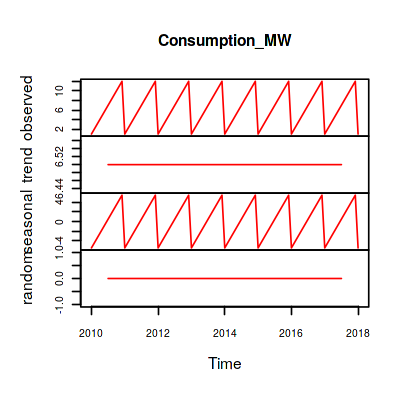

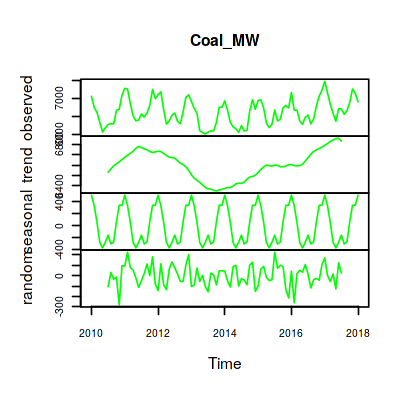

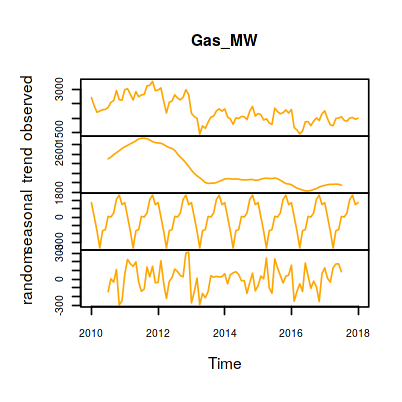

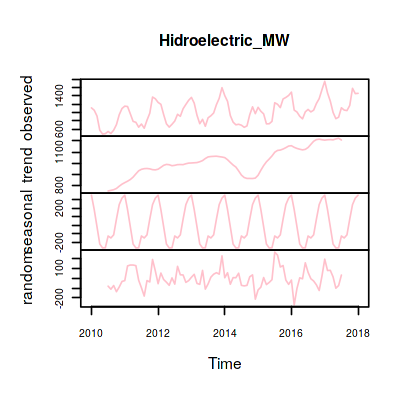

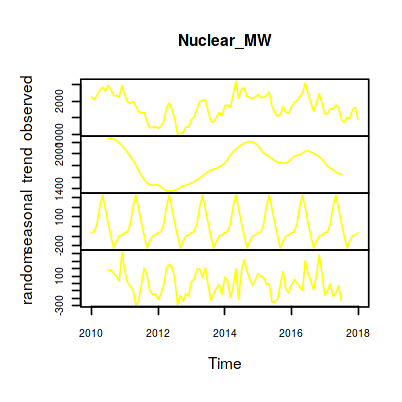

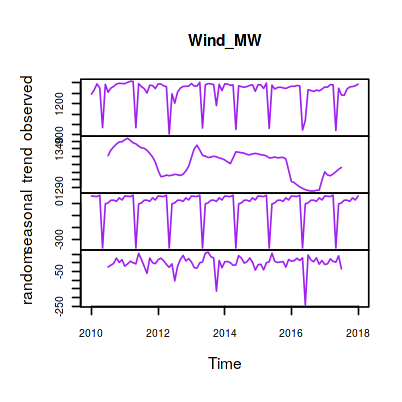

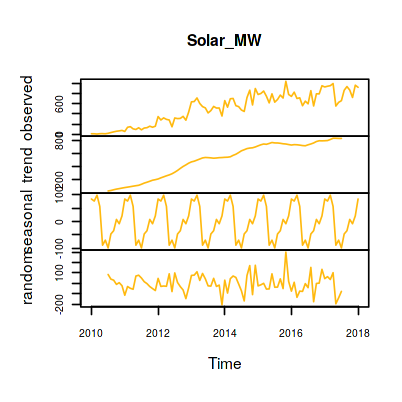

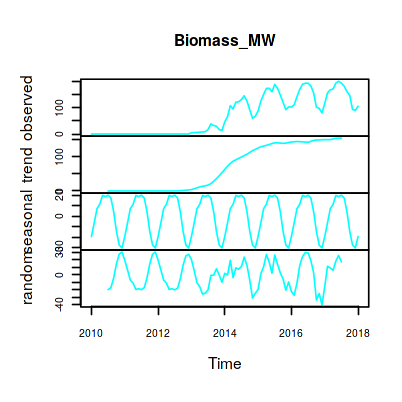

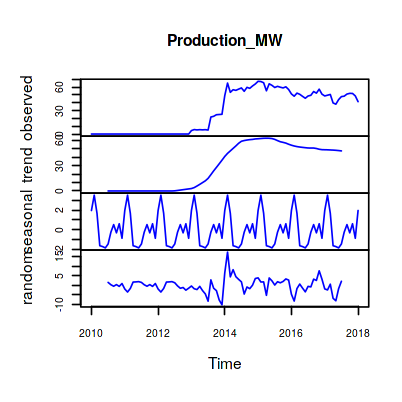

In [14]:
my_plot.decomposed.ts = function(df, monthwise.ts, start, end) 
{
    options(repr.plot.width=3.35, repr.plot.height=3.35)
  for (i in start:end)
    {
        decomposedRes <- decompose(monthwise.ts[,i], type="additive")
        plot(cbind(observed = decomposedRes$x, trend = decomposedRes$trend, seasonal = decomposedRes$seasonal, random = decomposedRes$random), 
             main=colnames(df)[i], col = colours[i-start+1], cex.main = 0.75, cex.lab = 0.75, cex.axis = 0.75)
    }
}
my_plot.decomposed.ts(df, monthwise.ts, 2,10)

We observe:
* The total production of coal has been contant over time.
* The total production of gas has been decreasing over time.
* The total production of hydroelectricity has been increasing over time.
* The total production of nuclear energy has been contant over time.
* The total production of wind energy has been decreasing over time.
* The total production of solar energy has been increasing over time.
* The total production of biomass energy has been increasing over time.

Note: Total magnitude of production has been increasing over time.

## Decomposition by Percentage

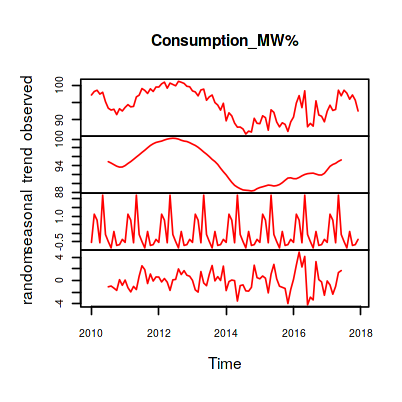

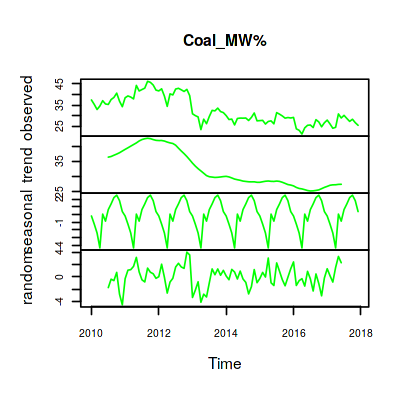

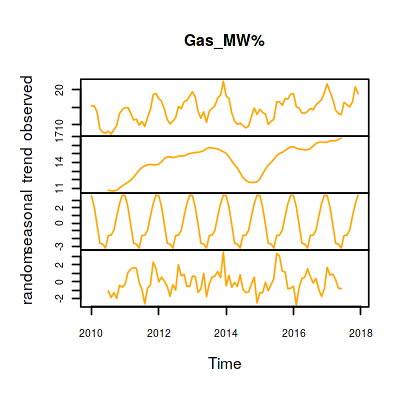

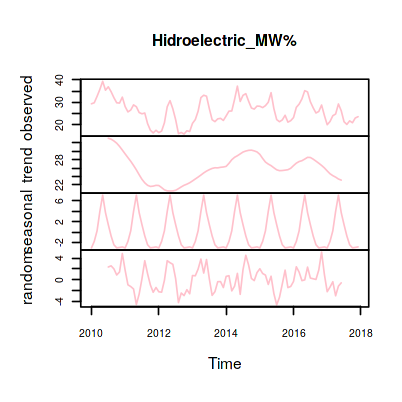

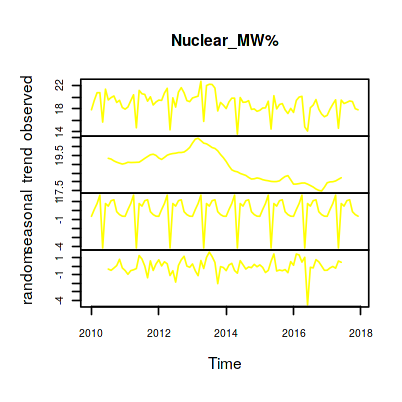

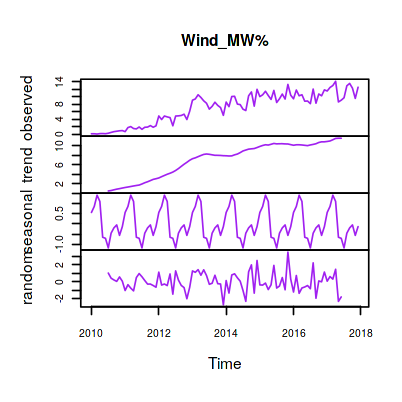

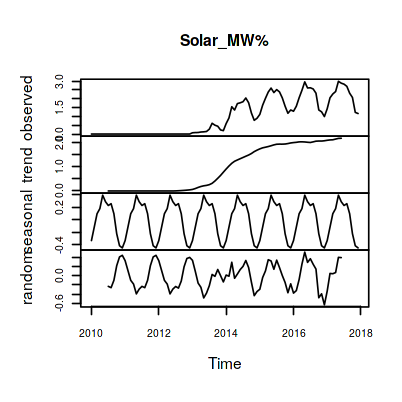

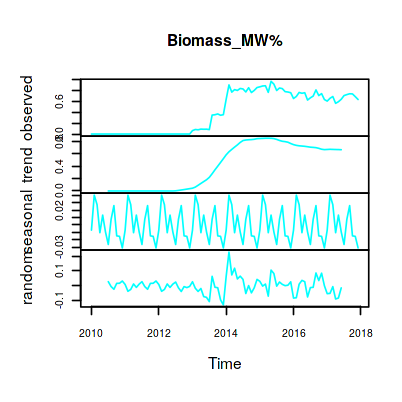

In [15]:
colours = c("red", "green", "orange", "pink", "yellow", "purple", "black", "cyan", "blue", "darkgoldenrod1")

sortedm = df[,2:14] %>%  group_by(Year, Month)  %>% summarise_each(funs(sum))
for (i in 3:10)
    sortedm[paste0(colnames(sortedm)[i],"%")] = sortedm[,i]/sortedm[,11]*100
sortedm.ts = ts(sortedm, frequency=12, start=c(2010,1), end=c(2017,12))
my_plot.decomposed.ts(sortedm, sortedm.ts, 14,21)


## Analysis
I further decompose the time series of the various factors (features) of electricity production. 

Observations:
* Coal as a source of electricity production deacreased from 35% of the total production in 2012 to 22% of the total production in 2017.
* The percentage of Gas in the total production of electricity decreased in 2015 and then increased to become like before.
* The percentage of Hydroelectricity in the total production of electricity decresed and then reamained more or less constant.
* The percentage of Nuclear Energy in the total production of electricity slightly increased in 2015 and then decreased.
* The percentage of Wind Energy in the total production of electricity increased from 2% in 2010 to 10% in 2017.
* The percentage of Solar Energy in the total production of electricity increased from 0% in 2013 to 2% in 2017.
* The percentage of Biomass in the total production of electricity increaaed from 0% in 2013 to 0.8% in 2016, after which it slightly dipped again.

Also note that Consumption of Electricity is significantly lower than the total production. Consumption was 94% of total production in 2010, rising to 99% in 2013, then falling to 89% in 2015, again rising to 94% in 2017.

[1] "% of total electricity production from renewable energy sources: 34.747249509106%"


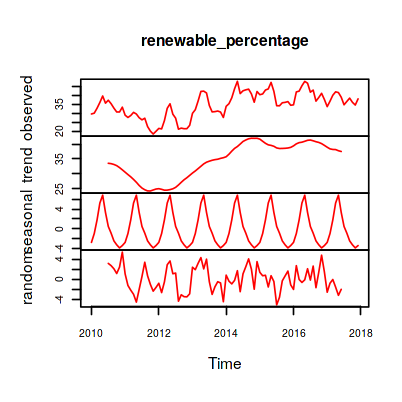

In [16]:
sortedm = df[,2:14] %>%  group_by(Year, Month)  %>% summarise_each(funs(sum))
sortedm$renewable = sortedm$Hidroelectric_MW + sortedm$Wind_MW + sortedm$Solar_MW + sortedm$Biomass_MW
sortedm$renewable_percentage = sortedm$renewable/sortedm$Production_MW*100
avg_percentage = sum(sortedm$renewable)/sum(sortedm$Production_MW)*100
print(paste0('% of total electricity production from renewable energy sources: ', avg_percentage, '%'))
sortedm.ts = ts(sortedm, frequency=12, start=c(2010,1), end=c(2017,12))
my_plot.decomposed.ts(sortedm, sortedm.ts, length(sortedm), length(sortedm))

We see that renewable energy (Hydroelectric, Wind, Solar, Biomass) as a percentage of total electricity production has been steadily increasing. On an average from 2010 to 2017, Romania has **34.75%** of its total electricity production from renewable energy sources. From *25% in 2012*, *38% * of Roamnia's entire electricity production was from renewable sources in *2017*. 

Moreover, Romania produces electricity well in excess of its total consumption. Thus, the country is self-sufficient in its energy needs, and is in a position to export electricity. Though coal is still one of the major sources of electricity production, other renewable sources (like biomass and solar energy) can be actively explored to reduce the dependence on non-renewable sources of energy.

The original **Renewable Energy Directive (2009/28/EC)** establishes an overall policy for the production and promotion of energy from renewable sources in the European Union. It requires the EU to fulfil at least *20%* of its total energy needs with renewables by *2020*. Romania has already met the current renewable energy directive.

The new directive establishes a new binding renewable energy target for the EU for *2030 *of at least *32%*, with a clause for a possible upwards revision by 2023. If Romania continues its current trend of production of electricity from renewable sources, it would easily meet this target as well. Wind and solar power have experienced rapid cost declines and are being deployed at scale. Since it is already ahead in its target fulfilment, Romania can further explore these options for domestic use as well as potential export to help other countries meet their sustainable energy goals. 

However, it is to be noted that the output variability of renewable sources remains a key problem for managing electricity systems, and more analysis needs to be done on multi-day to multi-year variability.

# Stationary Testing

When investigating a time series, one of the first things to check before building a forecasting model is to check that the series is stationary. That is, we need to check that the time series is constant in mean and variance are constant and not dependent on time.

In [17]:
multi_stat_tests<- function(df){
    p <- ncol(df)
    make.ts<- function(x)
    {
        ts(x, frequency=12, start=c(2010,1), end=c(2018,1)) 
    }
    df_multi <- data.frame(#var=names(df),
                           adf.pvalue=sapply(df, function(v) adf.test(make.ts(v),alternative = "stationary", k=10)$p.value),
                           kpss.pvalue=sapply(df, function(v) kpss.test(make.ts(v))$p.value)
                           )
    df_multi$adf <- ifelse (df_multi$adf.pvalue < 0.05, "Stationary", "Non-Stationary") 
    df_multi$kpss <- ifelse(df_multi$kpss.pvalue > 0.05, "Stationary", "Non-Stationary")
    df_multi
}
df_stat_tests = as.data.frame(multi_stat_tests(monthwise[,3:11]))
df_stat_tests

Warning message in adf.test(make.ts(v), alternative = "stationary", k = 10):
“p-value smaller than printed p-value”Warning message in kpss.test(make.ts(v)):
“p-value greater than printed p-value”Warning message in kpss.test(make.ts(v)):
“p-value smaller than printed p-value”Warning message in kpss.test(make.ts(v)):
“p-value greater than printed p-value”Warning message in kpss.test(make.ts(v)):
“p-value greater than printed p-value”Warning message in kpss.test(make.ts(v)):
“p-value smaller than printed p-value”Warning message in kpss.test(make.ts(v)):
“p-value smaller than printed p-value”Warning message in kpss.test(make.ts(v)):
“p-value smaller than printed p-value”

,adf.pvalue,kpss.pvalue,adf,kpss
,<dbl>,<dbl>,<chr>,<chr>
Consumption_MW,0.9483250,0.10000000,Non-Stationary,Stationary
Coal_MW,0.6327726,0.01000000,Non-Stationary,Non-Stationary
Gas_MW,0.5402030,0.01341830,Non-Stationary,Non-Stationary
Hidroelectric_MW,0.6124535,0.10000000,Non-Stationary,Stationary
Nuclear_MW,0.0100000,0.10000000,Stationary,Stationary
Wind_MW,0.9112412,0.01000000,Non-Stationary,Non-Stationary
Solar_MW,0.8564898,0.01000000,Non-Stationary,Non-Stationary
Biomass_MW,0.7926463,0.01000000,Non-Stationary,Non-Stationary
Production_MW,0.8790627,0.02224604,Non-Stationary,Non-Stationary


* The **Augmented Dickey–Fuller (ADF)** t-statistic test is used to find if the series has a unit root (a series with a trend line will have a unit root and result in a large p-value).
* We can test if the time series is level or trend stationary using the **Kwiatkowski-Phillips-Schmidt-Shin (KPSS)** test. We check the null hypothesis of trend stationarity (a low p-value will indicate a signal that is not trend stationary, has a unit root).

We see that the tests show our time series to be non-stationary (except Nuclear_MW).



# Time Series Forecasting

**Exponential Smoothing model (ETS) ** is appropriate for modeling non-stationary data. I have applied ETS on the time series of each of the features. Modelling the time series on the training data (2010-2018) I have forecast the time series for 12 months (2018-2019), which is the test data. I have overlaid the test data on my forecasted time series, to see (visually) how well my ETS model forecasts are; as a baseline for forcasting the test data. For forecasting *Consumption_MW*, I have used the sample values from the dataset `baseline_improved.csv`.

In [18]:
p <- plot_ly()
for (i in 4:11)
{
    fit <- ets(monthwise_pred.ts[,i])
    fore <- forecast(fit,h=12,level=c(80,95),model=fit)

p = p %>%
add_lines(x = time(monthwise.ts[,i]), y = monthwise.ts[,i], color = I("black"), name = "observed") %>%
  add_ribbons(x = time(fore$mean), ymin = fore$lower[, 2], ymax = fore$upper[, 2],
              color = I("gray95"), name = "95% confidence") %>%
  add_ribbons(x = time(fore$mean), ymin = fore$lower[, 1], ymax = fore$upper[, 1],
              color = I("gray80"), name = "80% confidence") %>%
  add_lines(x = time(fore$mean), y = fore$mean, color = I("blue"), name = "prediction") %>%
  add_lines(x = time(monthwise_test.ts[,i-1]), y = monthwise_test.ts[,i-1], color = I("green"), name = "test")

}
t = list()
for (i in 1:8)
    t[[i]] = c(rep(F, (i-1)*5), rep(T, 5), rep(F, (8-i)*5))
p = p %>%
layout(
    title = "Time Series Forecasting Plots",
    xaxis = list(title="Year", label= c('1','2','3','4','5','6','7')),
    yaxis = list(title = "Energy (in MW)"),
    updatemenus = list(
        list(
        y = 0.7,
        #    type="buttons",
        buttons = list(
            list(method = "restyle",
               args = list("visible", as.list(t[[1]])),
               label = colnames(df)[3]),
            
            list(method = "restyle",
               args = list("visible", as.list(t[[2]])),
               label = colnames(df)[4]),
            
            list(method = "restyle",
               args = list("visible", as.list(t[[3]])),
               label = colnames(df)[5]),
            
            list(method = "restyle",
               args = list("visible", as.list(t[[4]])),
               label = colnames(df)[6]),
            
            list(method = "restyle",
               args = list("visible", as.list(t[[5]])),
               label = colnames(df)[7]),
            
            list(method = "restyle",
               args = list("visible", as.list(t[[6]])),
               label = colnames(df)[8]),
            
            list(method = "restyle",
               args = list("visible", as.list(t[[7]])),
               label = colnames(df)[9]),
            
            list(method = "restyle",
               args = list("visible", as.list(t[[8]])),
               label = colnames(df)[10]) )
          
        )))

[This Time series Forecasting Plot](https://plot.ly/~asmitapoddar/10/#/) shows the forecasts of the time series of each feature. The *black* line is the observed data, the 80% and 95% confidence intervals have been shown (*grey* zones), the *blue* line is the prediction using the ETS models, and the *green* line is the actual test data.

In [19]:
fit <- ets(monthwise_pred.ts[,3])
fore <- forecast(fit,h=12,level=c(80,95),model=fit)

if(F){pp <- plot_ly() %>%
add_lines(x = time(monthwise.ts), y = monthwise.ts[,3], color = I("black"), name = "observed") %>%
  add_ribbons(x = time(fore$mean), ymin = fore$lower[, 2], ymax = fore$upper[, 2],
              color = I("gray95"), name = "95% confidence") %>%
  add_ribbons(x = time(fore$mean), ymin = fore$lower[, 1], ymax = fore$upper[, 1],
              color = I("gray80"), name = "80% confidence") %>%
  add_lines(x = time(fore$mean), y = fore$mean, color = I("blue"), name = "prediction") %>%
  add_lines(x = time(monthwise_test_con_pred.ts[,3]), y = monthwise_test_con_pred.ts[,3], color = I("green"), name = "predicted test values") %>%
  layout( title = "Forecast for Energy Consumption for 1 Year", xaxis = list(title ="Time"), yaxis = list(title = "Energy (in MW)"))
#pp
}      

[This Time series Forecasting Plot](https://plot.ly/~asmitapoddar/16/#/) shows the forecasts for the Consumption_MW time series.

# HeatMaps

I have created heatmaps depicting the consumption of electricity for every for every day of the month over 12 months. The consumption of electricity has been  aggregated *(mean)* over each day. I have constructed **8** such **31 X 12** heatmaps for each individual year of data given. 

[This Heatmap](http://bit.ly/EEMLHeatmap) shows the 9 heatmaps in one page for easy comparision and analysis. The 9th heatmap is an aggregated *(mean)* of the 8 heatmaps. The aggregate heatmap confirms that the pattern observed for each individual year is the general trend (pattern) observed over the years as a whole. 

The colour key shows the aggregate (*mean*) magnitude of electricity from **lowest (*yellow*)** to **highest (*black***). The **histogram (*cyan*)** overlaid on the colour key tells us the distribution of the aggreate magnitude of electricity consumption per day.

## Analysis

An overview of the heatmaps: 

### According to Days of the Week 
We can observe that the pattern of colours repeat over a **~7** day period. In general, we see **5** darker coloured days followed by **2** lighter coloured days. This indicates that more electricity is consumed over the weekdays as compared to the weekends.
This is further confirmed by the aggregate (*mean*) of electricity consumption over weekends and weekdays both yearwise, and over 8 years. The electricity consumption is lesser on Sundays as compared to Saturdays.

### According to Weather
We see that during the winter months in Romania *(Nov, Dec, Jan, Feb, Mar)*, more electricity is consumed (darker coloured squares) as compared to the summer months. 
Though more electricity is consumed on weekends in winter as compared to summer months, electricity consumed on weekends is lesser than the electricity consumed on weekdays.

### According to National Holidays
From the list of public holidays in Romania (https://www.timeanddate.com/holidays/romania/),

* 1st - 2nd Jan: 1st Jan has lesser energy consumption as compared to the rest of the month (all shops are closed after New Years Celebrations?), while 2nd Jan sees a spike up in the electricity consumption.
* 24th Jan: There does not seem to be change in electricity consumption due to this national holiday.
* 26th Apr - 1st May: The consumption is slightly lower as compared to the general consumption pattern over the weekdays and weekends during the rest of the month.
* 1st June: There does not seem to be change in electricity consumption due to this national holiday.
* 16th - 17th June: The consumption follows the general pattern as seen during weekdays and weekends.
* 15th Aug: There does not seem to be change in electricity consumption due to this national holiday.
* 30th Nov - 1st Dec: These days see a spike in the electricity consumption. (Maybe people like to stay indoors during this cold break.)
* 25th - 26th Dec: The week of Christmas (esp. 25th and 26th Dec) has lower electricity consumption as compared to the rest of the month. It could be because offices are closed and people take holidays during that period.

It is interesting to note that the electricity consumption spikes up greatly around the 12th of every month, though I could not attribute a reason to it.


In [20]:
sorted = df[,2:14] %>%  group_by(Year, Month, Day)  %>% summarise_each(funs(mean))
unique_years = unique(sorted$Year)
df_byday = list()
for (i in 1:length(unique_years))
{
    s = sorted[sorted$Year==unique_years[i],]
    tmp <- data.frame(x = s$Month, y = s$Day, z = s$Consumption_MW)
    df_byday[[i]] = acast(tmp, x~y, value.var="z")
}    
names(df_byday) = as.character(unique_years)

min_c = min(unlist(lapply(df_byday, function(x) min(x, na.rm=T))))
max_c = max(unlist(lapply(df_byday, function(x) max(x, na.rm=T))))
b = seq(min_c,max_c,length=366)
                          
colfunc <- colorRampPalette(c( "lightyellow","yellow", "orange", "red", "darkred", "black"))
options(repr.plot.width=5, repr.plot.height=5)
h = list()                          
for (i in 1:8)
{heatmap.2(df_byday[[i]], Rowv=F, Colv=F, dendrogram="none", scale="none", col=colfunc(365), trace="none", 
            margins=c(3.2,3), ColSideColors = colfunc(31), key = T, tracecol="cyan", keysize = 2.5, 
           breaks= b, density.info="histogram", xlab = "Day", ylab = "Month", na.rm=T,
            main=names(df_byday)[i], key.title = "Colour Key", key.xlab = "Consumption_MW", key.ylab = NULL, 
           key.par=list(cex.main=0.75, cex.axis=0.65,cex.lab=0.85), lwid = c(1,2), lhei= c(.855,2))
 }

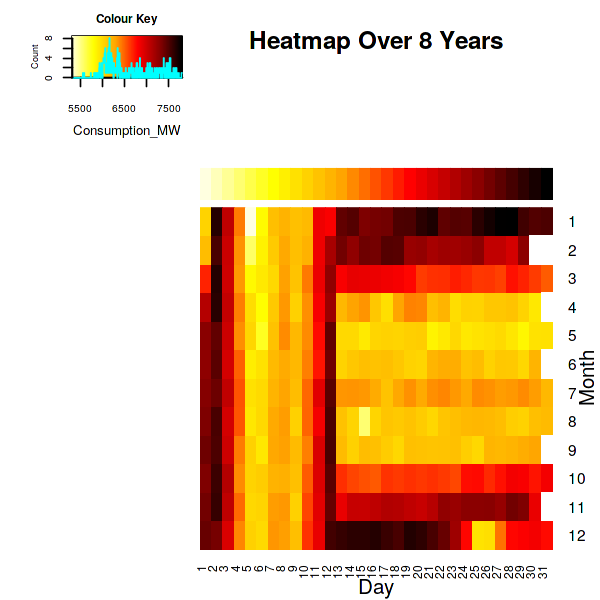

In [21]:
sorted1 = df[,2:14] %>%  group_by(Month, Day)  %>% summarise_each(funs(mean))
all <- data.frame(x = sorted1$Month, y = sorted1$Day, z = sorted1$Consumption_MW)
all = acast(all, x~y, value.var="z")

min_c = min(all, na.rm=T)
max_c = max(all, na.rm=T)
b = seq(min_c,max_c,length=366)
heatmap.2(all, Rowv=F, Colv=F, dendrogram="none", scale="none", col=colfunc(365), trace="none", margins=c(3.2,3), 
          ColSideColors = colfunc(31), key = T, tracecol="cyan", keysize = 2.5, breaks= b, 
          density.info="histogram", xlab = "Day", ylab = "Month", na.rm=T,
           main="Heatmap Over 8 Years", key.title = "Colour Key", key.xlab = "Consumption_MW", key.ylab = NULL, 
           key.par=list(cex.main=0.75, cex.axis=0.65,cex.lab=0.85), lwid = c(1,2), lhei= c(.855,2))